[*********************100%***********************]  1 of 1 completed


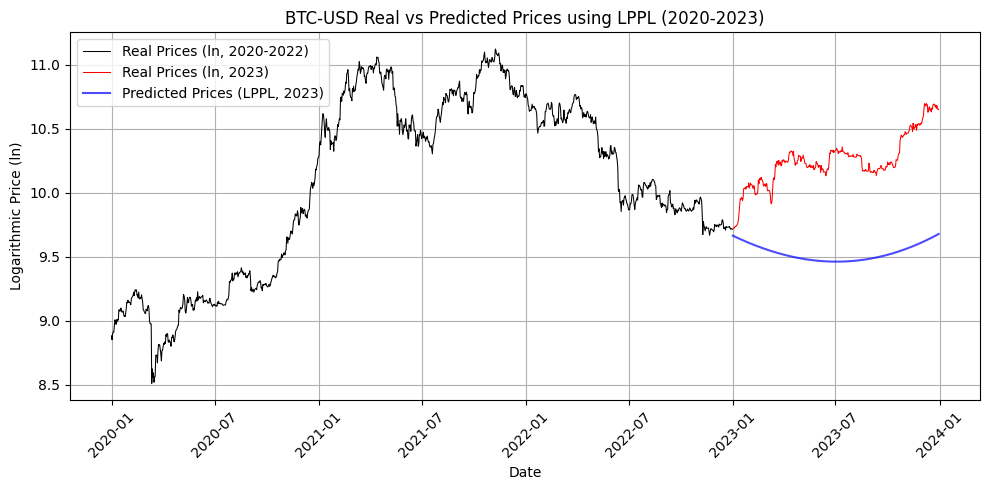

In [10]:
# Importy
import yfinance as yf
from lppls import lppls
import numpy as np
import pandas as pd
from datetime import datetime as dt
from matplotlib import pyplot as plt

# Funkcja pobierająca dane z yfinance
def get_crypto_data(symbol, start_date, end_date):
    crypto_data = yf.download(symbol, start=start_date, end=end_date)
    return crypto_data

crypto_symbol = "BTC-USD"
start_date = "2020-01-01"
end_date = "2023-12-31"

data = get_crypto_data(crypto_symbol, start_date, end_date)

# Przetwarzanie daty i ceny
data['Date'] = data.index

# Podzielenie danych na okres nauki (2020-2022) i okres testowy (2023)
train_data = data.loc['2020-01-01':'2022-12-31']  # Dane do nauki
test_data = data.loc['2023-01-01':'2023-12-31']   # Dane rzeczywiste na 2023

# Przetwarzanie danych dla modelu
time_train = [pd.Timestamp.toordinal(d) for d in train_data['Date']]
price_train = np.log(train_data['Close'].values)  # Logarytm z ceny zamknięcia

# Tworzenie macierzy obserwacji dla modelu LPPL
observations = np.array([time_train, price_train])
MAX_SEARCHES = 100  # Zwiększenie liczby wyszukiwań

# Dopasowanie modelu LPPL
lppls_model = lppls.LPPLS(observations=observations)
tc, m, w, a, b, c, c1, c2, O, D = lppls_model.fit(MAX_SEARCHES)

# Prognoza modelu LPPL dla okresu testowego (2023)
test_dates = test_data['Date']
time_test = [pd.Timestamp.toordinal(d) for d in test_dates]
lppls_predictions = [lppls_model.lppls(t, tc, m, w, a, b, c1, c2) for t in time_test]

# Wykres rzeczywistych cen (dla danych treningowych) oraz rzeczywiste i przewidywane ceny na 2023 rok
time_ord_train = [pd.Timestamp.fromordinal(d) for d in lppls_model.observations[0, :].astype('int32')]

plt.figure(figsize=(10, 5))

# Wykres rzeczywistych danych (2020-2022)
plt.plot(time_ord_train, price_train, label='Real Prices (ln, 2020-2022)', color='black', linewidth=0.75)

# Wykres rzeczywistych danych (2023)
plt.plot(test_data['Date'], np.log(test_data['Close']), label='Real Prices (ln, 2023)', color='red', linewidth=0.75)

# Wykres przewidywanych cen (na 2023)
plt.plot(test_dates, lppls_predictions, label='Predicted Prices (LPPL, 2023)', color='blue', alpha=0.7)

plt.grid(True)
plt.xlabel('Date')
plt.ylabel('Logarithmic Price (ln)')
plt.title(f'{crypto_symbol} Real vs Predicted Prices using LPPL (2020-2023)')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()
